In this notebook, we explore visual representations of the relationship of the data in EmoDB and the most important features from our best model SVM with 100.00% train and 85.10% test F1 macro score.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.io as pio
import plotly.graph_objs as go
import pickle
import math
import itertools

# packages for model
import sklearn
from sklearn.svm import SVC

# import own functions
from ipynb.fs.full.Functions import load_train_test_data, model_eval, run_gridsearchCV, load_model, feature_importance

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load most important 215 features from featurewiz selection on 70-30 split
with open('../results/most_important_features_70_30_split_215.pkl', 'rb') as f:
    most_imp_features = pickle.load(f)

# select features from df prep with all stats    
df_all_stats = pd.read_pickle('../results/df_prep_numerical_only_all_stats.pkl')
    
df_most_important215 = df_all_stats[most_imp_features]
df_most_important215['label'] = df_all_stats['label']

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_most_important215, verbose=False, test_size=0.3)


Evaluation: f1_score
100.00% for the train data
85.10% for the test data

Evaluation: accuracy_score
100.00% for the train data
85.71% for the test data

Evaluation: precision_score
100.00% for the train data
87.27% for the test data

Evaluation: recall_score
100.00% for the train data
83.98% for the test data

Evaluation: confusion_matrix of test predictions


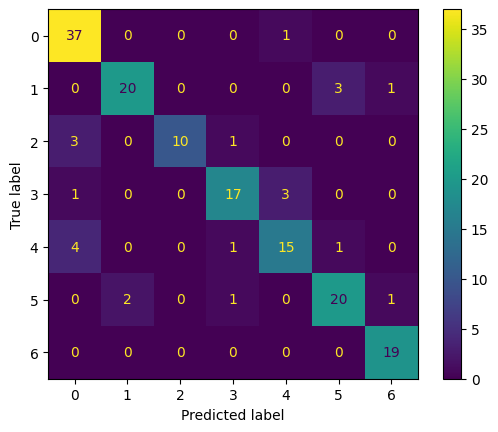


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)']



In [3]:
# load best model
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
model_eval(svm_best_model, X_train, X_test, y_train, y_test, confusion=True)

RBF kernel. Computing permutation importance.


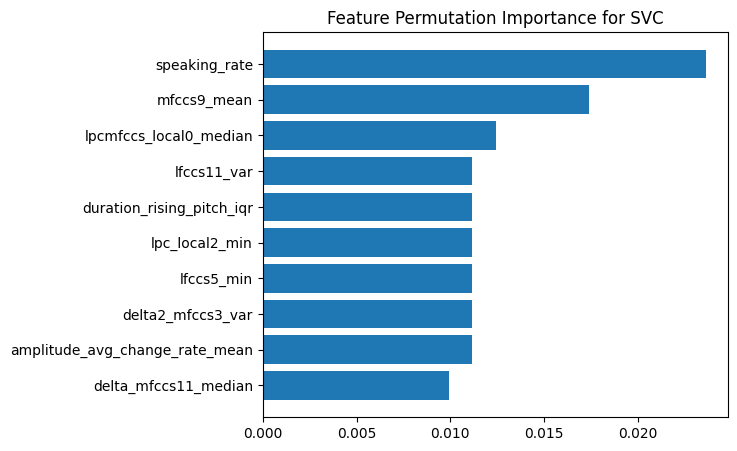

In [4]:
feature_imp_svm = feature_importance(svm_best_model, X_test, y_test, top=10)

In [24]:
def plot_boxplots(df, features, graphs_per_row):
    num_features = len(features)
    num_rows = math.ceil(num_features / graphs_per_row)

    fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 4*num_rows))
    fig.suptitle('Box Plots: Feature vs. Target', fontsize=16)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Get target values from the dataframe
    target_values = df['label'].values

    for i, feature in enumerate(features):
        ax = axes[i // graphs_per_row, i % graphs_per_row] if num_rows > 1 else axes[i % graphs_per_row]

        # Get feature values from the dataframe
        feature_values = df[feature].values

        # Grouping feature values by target label
        data = {}
        for feature_val, target_val in zip(feature_values, target_values):
            if target_val not in data:
                data[target_val] = []
            data[target_val].append(feature_val)
        
        # Sort the keys for better overview
        sorted_keys = sorted(data, key=lambda x: int(x))
        data = [data[label] for label in sorted_keys]

        # Creating the box plot
        ax.boxplot(data)

        # Customizing the plot
        ax.set_title(feature)
        ax.set_xlabel('Target Label')
        ax.set_ylabel('Feature')

        # Adding x-axis labels
        ax.set_xticklabels(sorted_keys)

    # Removing any empty subplots
    if num_features < num_rows * graphs_per_row:
        for i in range(num_features, num_rows * graphs_per_row):
            ax = axes[i // graphs_per_row, i % graphs_per_row] if num_rows > 1 else axes[i % graphs_per_row]
            fig.delaxes(ax)
    
    #plt.savefig('../results/visualizations/feature_target_box.svg', bbox_inches='tight')
    plt.show()

In [8]:
# creat train df
train_df = pd.concat([X_train, y_train], axis=1)

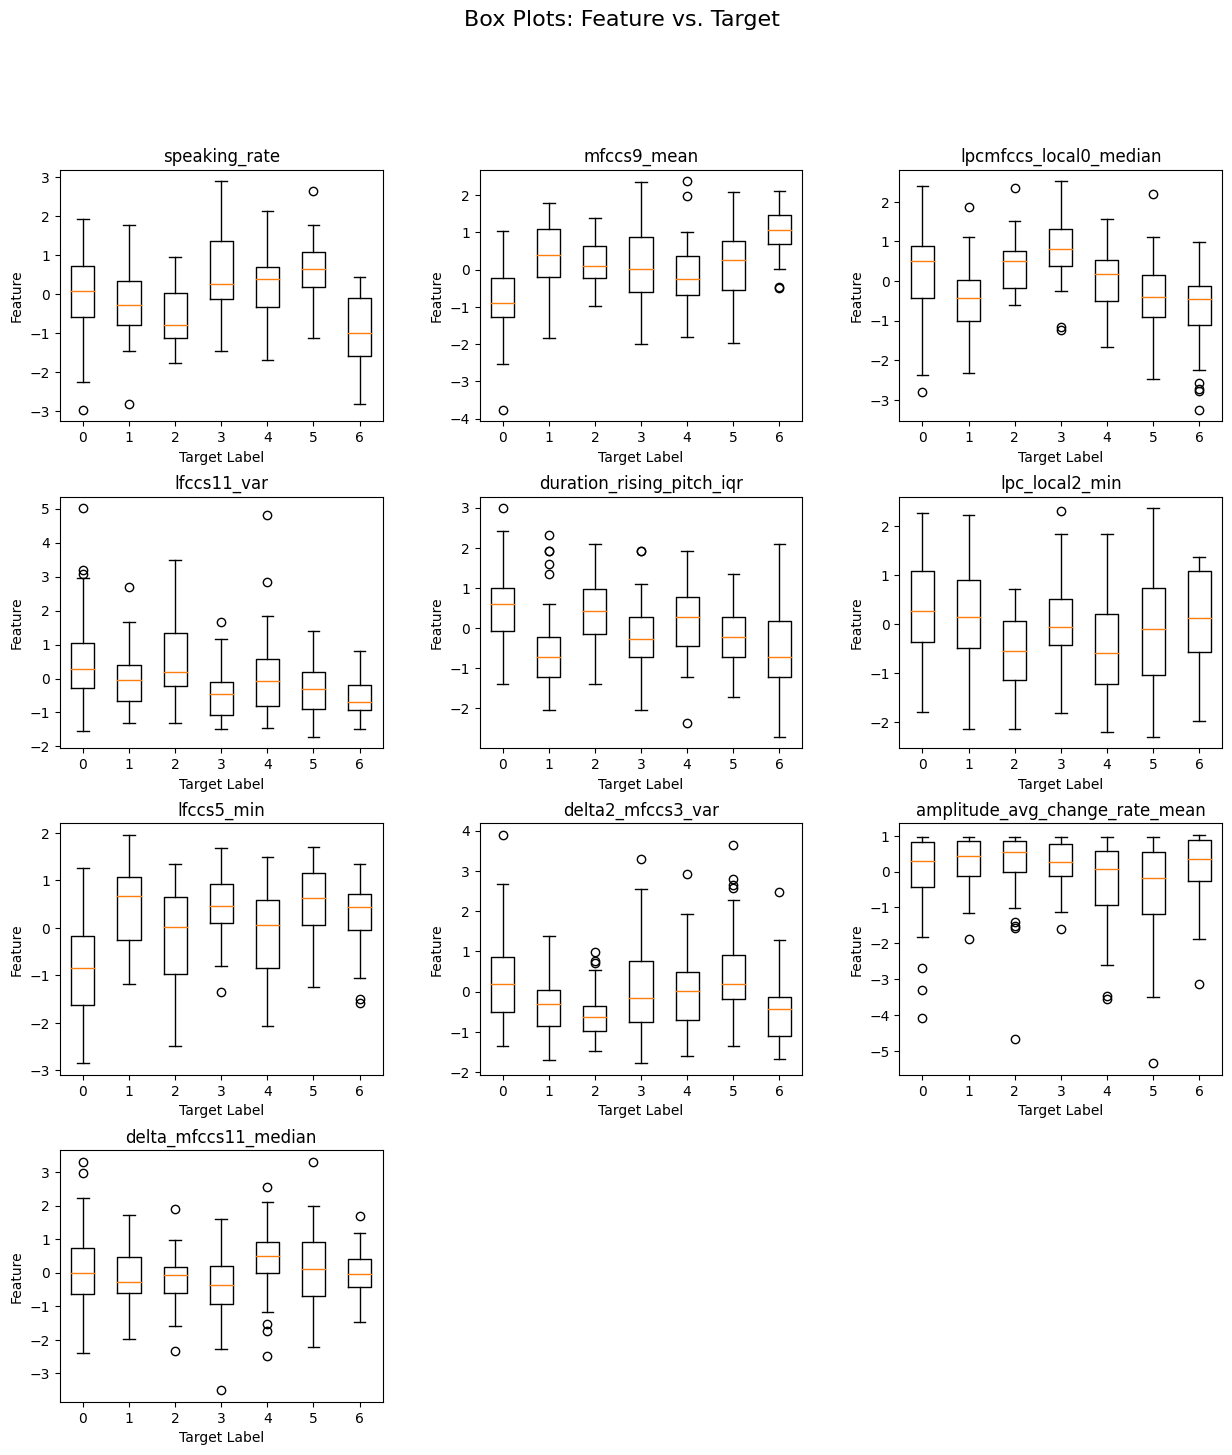

In [26]:
plot_boxplots(train_df, feature_imp_svm, 3)

- anger (0) and happiness (4) have quite similar IQR regions for many features like speaking_rate, lpcmfccs_local0_median, or lfccs11_var; however, mfccs9_mean, lpc_local2_min, or lfccs5_min seem helpful for distinguishing between these two emotions since the IQRs are shifted in their range (even though lpc_local2_min has quite large whiskers). Additionally, delta_mfccs11_median has a rather small IQR region which could help for the distinction. 
- mfccs9_mean should in general be quite good for distinguishing anger (0), as well as sadness (6) since the IQR have quite distinct and rather small regions for these emotions. Similarly, lfccs5_min seems a good indicator for anger (0). 
- boredom (1) and neutral (5) have quite similar IQRs in many features like mfccs9_mean, lpcmfccs_local0_median, or lfccs11_var. However, especially speaking_rate but also duration_rising_pitch_iqr and delta2_mfccs3_var show a great distinction between these two emotions
- disgust (2) and anger (0) also has many similar IQR regions for the features. Nonetheless, speaking_rate and mfccs9_mean (the first two features) should help here. 
- Overall, most features have similar lengths of IQRs between the classes. For some features and classes, they are rather big like in lpc_local2_min for all emotions except fear (3), for others they are rather small indicating a smaller spread in data (like neutral (5) in speaking_rate or sadness in mfccs9_mean)
- amplitude_avg_change_rate_mean has quite small and similar IQRs. The features is pobably only that helpful because happiness (4) and neutral (5) show differnt behavior. It also has more outliers than other features.
- We can clearly see why the combination of the different features in helpful
- Overall, the combination of these relationships with the target variable helps the model to make a suitable classification. Nonetheless, there is still room for improvement.

In [27]:
def plot_violinplots(df, features, graphs_per_row):
    num_features = len(features)
    num_rows = math.ceil(num_features / graphs_per_row)

    fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 4*num_rows))
    fig.suptitle('Violin Plots: Feature vs. Target', fontsize=16)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Get target values from the dataframe
    target_values = df['label'].values

    for i, feature in enumerate(features):
        ax = axes[i // graphs_per_row, i % graphs_per_row] if num_rows > 1 else axes[i % graphs_per_row]

        # Get feature values from the dataframe
        feature_values = df[feature].values

        # Grouping feature values by target label
        data = {}
        for feature_val, target_val in zip(feature_values, target_values):
            if target_val not in data:
                data[target_val] = []
            data[target_val].append(feature_val)
            
        # Sort the keys for better overview
        sorted_keys = sorted(data, key=lambda x: int(x))
        data = [data[label] for label in sorted_keys]
        
        # Creating the violin plot
        vp = ax.violinplot(data, showmedians=True)
        
        # Customizing the plot
        ax.set_title(feature)
        ax.set_xlabel('Target Label')
        ax.set_ylabel('Feature')

        # Adding x-axis labels
        ax.set_xticks(range(1, len(sorted_keys) + 1))
        ax.set_xticklabels(sorted_keys)

    # Removing any empty subplots
    if num_features < num_rows * graphs_per_row:
        for i in range(num_features, num_rows * graphs_per_row):
            ax = axes[i // graphs_per_row, i % graphs_per_row] if num_rows > 1 else axes[i % graphs_per_row]
            fig.delaxes(ax)
    
    #plt.savefig('../results/visualizations/feature_target_violin.svg', bbox_inches='tight')
    plt.show()

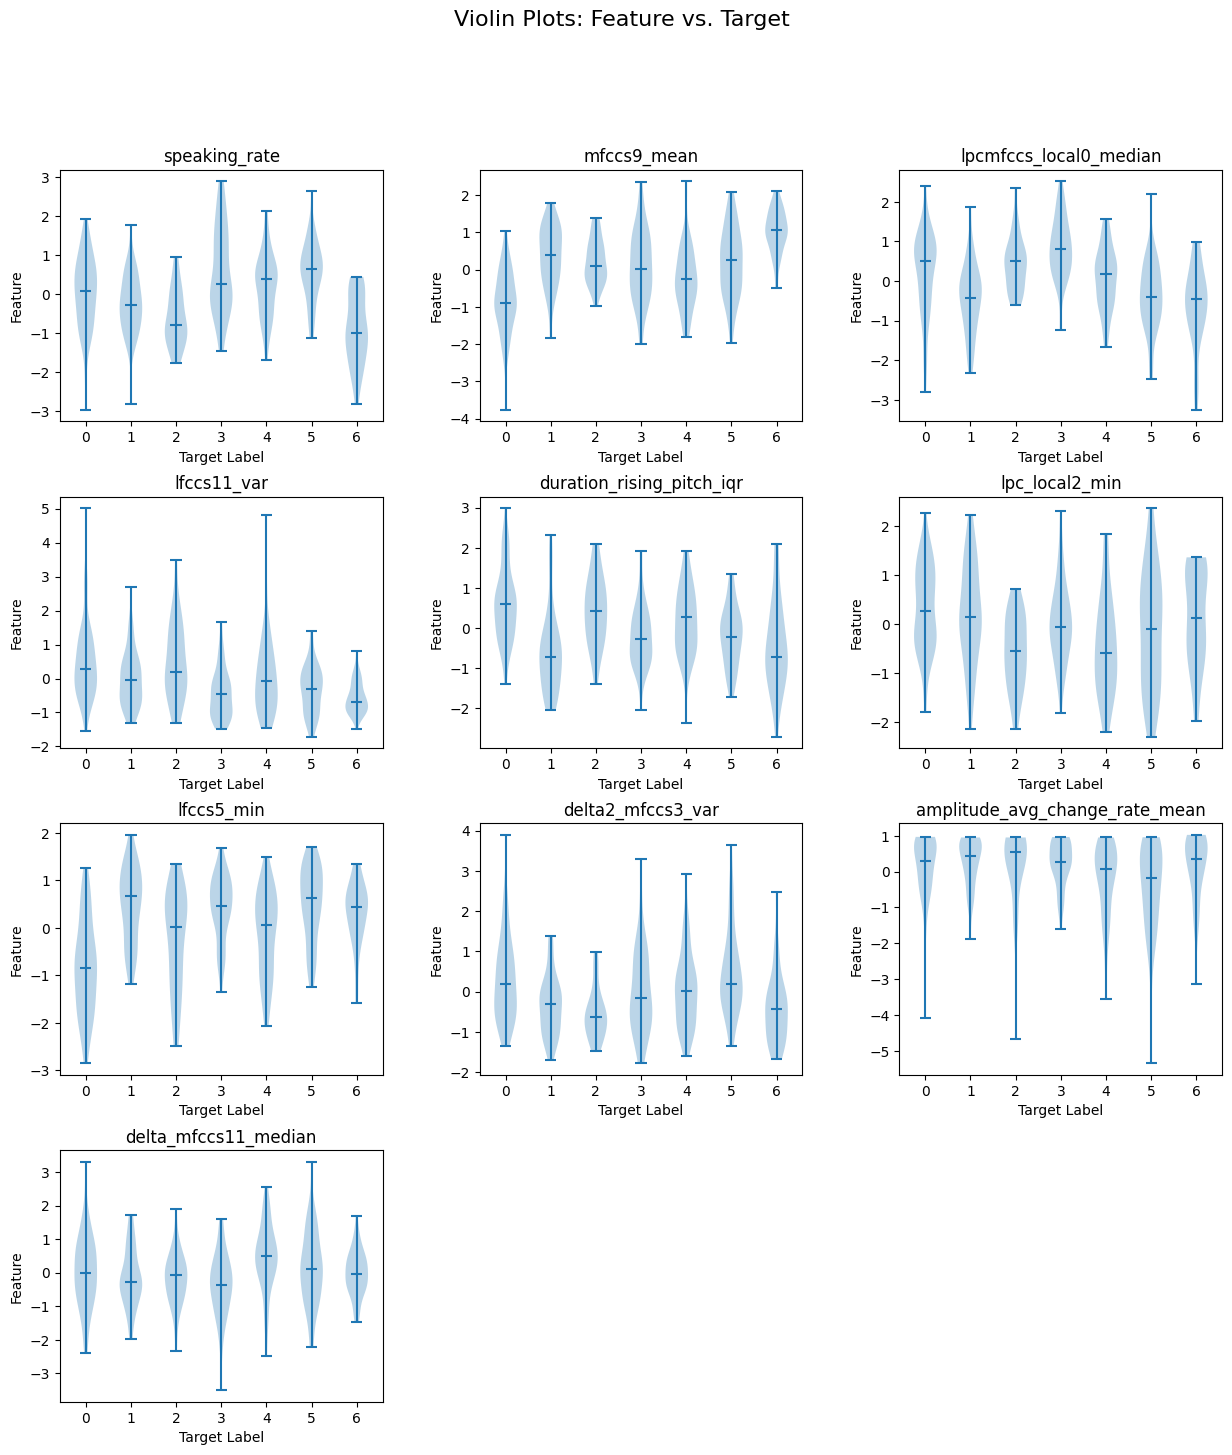

In [28]:
plot_violinplots(train_df, feature_imp_svm, 3)

The violines help us in better understanding the data distribution according to the features.

- features like mfccs9_mean, lpc_local2_min, delta_mfccs11_median have rather centered distributions for all classes, for other features there is often a tendency to one side (like downwards for lfccs11_var or upwards with amplitude_avg_change_rate_mean) which shows skewness of the data and more outlier behavior. 
- Most violins are bimodal
- As already seen before, lpc_local2_min has a wide spread in data range but for disgust (2), the data is also much more centered for fear (3)
- Even though having similar IQR regions, anger (0) and happiness (4) have a slightly different distribution in duration_rising_pitch_iqr, similarly for delta_mfccs11_median
- Similar things apply for boredom (1) and neutral (5) in amplitude_avg_change_rate_mean
- With these distributions we can also see why other class differentiations are easier

# Best visual representation in a 3D room

In [5]:
def find_best_3d_representation(df, feature_names, graphs_per_row):
    
    features = df[feature_names].values
    target_labels = df['label'].values

    # Generate all possible combinations of 3 features
    combinations = list(itertools.combinations(range(len(feature_names)), 3))
    
    # Extract number of rows to plot for subplots
    num_combinations = len(combinations)
    num_rows = math.ceil(num_combinations / graphs_per_row)
    
    # Create figure
    fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 4*num_rows), subplot_kw={'projection': '3d'})
    plt.subplots_adjust(left=0.05, right=0.8, bottom=0.05, top=0.95, wspace=0.00000000001, hspace=0.3)
    
    best_score = 0
    best_combination = None

    # Evaluate and compare each combination
    for i, combination in enumerate(combinations):
        ax = axes[i // graphs_per_row, i % graphs_per_row] if num_rows > 1 else axes[i % graphs_per_row]
        #ax = fig.add_subplot(num_rows, graphs_per_row, i+1, projection='3d')
        
        # Extract features for the current combination
        selected_features = features[:, combination]

        # Create the scatter plot
        for label in np.unique(target_labels):
            indices = np.where(target_labels == label)
            ax.scatter(selected_features[indices, 0], selected_features[indices, 1], selected_features[indices, 2], label=f'Class {label}')
        ax.set_xlabel(feature_names[combination[0]], fontsize=8)
        ax.set_ylabel(feature_names[combination[1]], fontsize=8)
        ax.set_zlabel(feature_names[combination[2]], fontsize=8)
        ax.zaxis.labelpad=-0.7
        ax.set_aspect('equal')

        # Calculate the score based on class separability
        score = len(combinations) / ax.dist

        # Update the best combination if the score is higher
        if score > best_score:
            best_score = score
            best_combination = combination
    
    # Removing any empty subplots
    if num_combinations < num_rows * graphs_per_row:
        for i in range(num_combinations, num_rows * graphs_per_row):
            ax = axes[i // graphs_per_row, i % graphs_per_row] if num_rows > 1 else axes[i % graphs_per_row]
            fig.delaxes(ax)
    
    plt.show()

    # Return the best combination of features
    print('The best feature combination for a visual representation is: {}'.format([feature_names[i] for i in best_combination]))

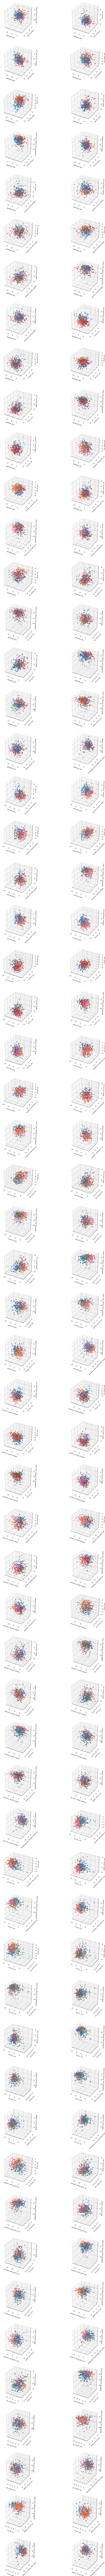

The best feature combination for a visual representation is: ['speaking_rate', 'mfccs9_mean', 'lpcmfccs_local0_median']


In [15]:
find_best_3d_representation(train_df, list(feature_imp_svm), 2)

As exptected, the combination of the three most important features ('rms_min', 'value_falling_pitch_iqr', 'lpc_global_mean') provides also the best visual representation for the classes in a 3D room. We can have a closer look with an interactive 3D map.

In [6]:
def scatter_plot_3d_interactive(df, features):
    data = [
        go.Scatter3d(
            x=df[features[0]],
            y=df[features[1]],
            z=df[features[2]],
            mode='markers',
            marker=dict(
                size=5,
                color=df['label'],
                colorscale='Viridis',
                opacity=0.8, 
                colorbar=dict(title='Target')
            )
        )
    ]

    layout = go.Layout(
        scene=dict(
            xaxis=dict(title=features[0]),
            yaxis=dict(title=features[1]),
            zaxis=dict(title=features[2])
        ),
        title='Interactive 3D Scatter Plot'
    )

    #fig = go.Figure(data=data, layout=layout)
    fig = go.FigureWidget(data=data, layout=layout)
    fig
    
    return fig

In [9]:
fig = scatter_plot_3d_interactive(train_df, ['speaking_rate', 'mfccs9_mean', 'lpcmfccs_local0_median'])
fig

FigureWidget({
    'data': [{'marker': {'color': array([0, 6, 3, ..., 6, 1, 1]),
                         'colorbar': {'title': {'text': 'Target'}},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888888,
                                        '#b5de2b'], [1.0, '#fde725']],
                         'opacity': 0.8,
                         'size': 5},
              'mode': 'markers',
              'type': 'scatter3d',
              'uid': '0d6cbb6c-6bf0-44c2-92b

In [16]:
# get reference to camera eye object
eye = fig.layout.scene.camera.eye

# Commit changes back to object
eye.x = eye.x
eye.y = eye.y
eye.z = eye.z

# save current view as image
fig.write_image('../results/visualizations/3D_representation3.svg')

- sadness (6) is the most easiest to distinguish across lpcmfccs_local0_median and speaking_rate.
- anger (0) and happiness (4) generally have many data points over a big regions.
- anger (0) is in general harder to distinguish but across mfccs9_mean is has rather low values compared to the other emotions (could be seen in violins as well)
- In general quite a overlap in the middle of the features where everything is centered.
- neutral (5) is mainly distinguishable across the plane of the two coefficient variables. boredom (1) appears around that region too but shifts for speaking_rate to rather lower values (makes sense!).
</br> </br> 
We also want to get real numbers of min and max for these features:

In [31]:
for feat in ['speaking_rate', 'mfccs9_mean', 'lpcmfccs_local0_median']:
    print('\n The summary statistics for {} are:'.format(feat))
    display(train_df.groupby('label')[feat].describe())


 The summary statistics for speaking_rate are:


count      mean       std       min       25%       50%       75%  \
label                                                                      
0       89.0  0.032750  0.940742 -2.970203 -0.580758  0.073203  0.705417   
1       57.0 -0.260883  0.776294 -2.829811 -0.787877 -0.276291  0.342426   
2       32.0 -0.625716  0.719373 -1.763457 -1.125493 -0.785478  0.013068   
3       48.0  0.598733  1.105503 -1.455519 -0.133220  0.265533  1.368607   
4       50.0  0.222494  0.827240 -1.691148 -0.336446  0.379269  0.694507   
5       55.0  0.577441  0.766374 -1.135519  0.180900  0.647968  1.072669   
6       43.0 -0.921968  0.880563 -2.823588 -1.586267 -1.009641 -0.111588   

            max  
label            
0      1.920777  
1      1.769525  
2      0.955054  
3      2.893160  
4      2.133123  
5      2.633172  
6      0.439149


 The summary statistics for mfccs9_mean are:


count      mean       std       min       25%       50%       75%  \
label                                                                      
0       89.0 -0.839987  0.851674 -3.759000 -1.270927 -0.894292 -0.213521   
1       57.0  0.377265  0.799984 -1.847909 -0.201170  0.386737  1.090977   
2       32.0  0.214623  0.604270 -0.964217 -0.218239  0.100023  0.622453   
3       48.0  0.087069  0.962639 -2.008120 -0.607014  0.020554  0.865495   
4       50.0 -0.223438  0.869808 -1.819498 -0.681632 -0.263900  0.350802   
5       55.0  0.181967  0.926985 -1.961195 -0.538042  0.264040  0.758012   
6       43.0  1.008634  0.601059 -0.504665  0.697203  1.060740  1.466289   

            max  
label            
0      1.044032  
1      1.784391  
2      1.384246  
3      2.353798  
4      2.371125  
5      2.079749  
6      2.107806


 The summary statistics for lpcmfccs_local0_median are:


count      mean       std       min       25%       50%       75%  \
label                                                                      
0       89.0  0.205797  1.038680 -2.811898 -0.439261  0.496066  0.888930   
1       57.0 -0.450566  0.863351 -2.317022 -1.011500 -0.422812  0.014256   
2       32.0  0.432473  0.687656 -0.598940 -0.170374  0.509257  0.747799   
3       48.0  0.814460  0.795427 -1.232044  0.382377  0.806276  1.315651   
4       50.0  0.063189  0.786513 -1.656913 -0.516478  0.173964  0.528718   
5       55.0 -0.391374  0.876551 -2.467925 -0.906031 -0.412641  0.145665   
6       43.0 -0.632577  1.001479 -3.251654 -1.101692 -0.453115 -0.115162   

            max  
label            
0      2.404786  
1      1.867608  
2      2.350180  
3      2.519925  
4      1.554413  
5      2.185257  
6      0.976446

With these observations, it is at least possible to have a visualization of emotions between different audio features. Even though, some are a bit hard to differentiate, we can get an understanding of how features like speaking rate, mfccs, or lpcmfccs in speech change with different emotions. Specifically, anger (0) and sadness (6) are very different in this 3D arangement. We can understand why anger (0) and happiness (4), as well as boredom (1) and neutral (5) are hard to distinguish just by looking at the data distribution. Also the distributions for neutral (5) and boredom (1) are much more dense then for other emotions indicating a lesser variability in the given features.